In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from strategy_implementation import profit_loss_balance, final_balance, buy_hold

df = pd.read_csv("TSLA_weekly_return_volatility.csv")
df.tail()

,Year,Week_Number,mean_return,volatility,label
311,2019,48,0.36400,1.229538,red
312,2019,49,1.31060,1.159313,green
313,2019,50,2.53600,2.812083,green
314,2019,51,1.50175,1.431817,green
315,2019,52,-1.38400,3.194708,red


In [2]:
# define functions
# Split dataset
def X(df):
    X = df.loc[:, ["mean_return", "volatility"]].values
    return X

def Y(df):
    Y = df.loc[:, "label"].values
    return Y

# Feature scaling, standardize data between -1 and 1
def split_and_scale(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=3)
    scale_X = StandardScaler().fit(X_train)
    X_train = scale_X.transform(X_train)
    X_test = scale_X.transform(X_test)
    return X_train, X_test, Y_train, Y_test

# Define the model
def prediciton_k(k, X_train, X_test, Y_train):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    pred_y = knn_classifier.predict(X_test)
    return pred_y

## 1. Find the optimal value of k with 2018 data

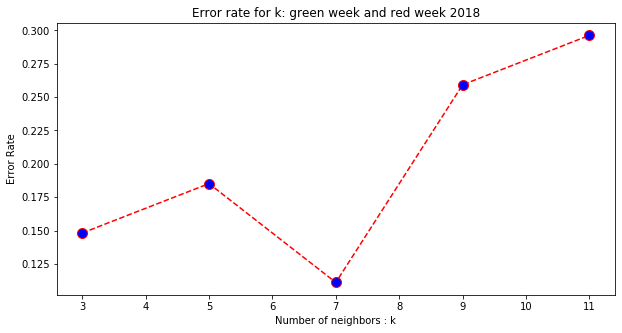

In [3]:
# 2018 data
df_18 = df.loc[df["Year"] == 2018].reset_index()

# test k with 2018 data
X_18 = X(df_18)
Y_18 = Y(df_18)
X_train, X_test, Y_train, Y_test = split_and_scale(X_18, Y_18)
error_rate = []
for k in range (3, 12 ,2):
    pred_y = prediciton_k(k, X_train, X_test, Y_train)
    error_rate.append(np.mean(pred_y != Y_test))
    
# plot k and error rate
fig = plt.figure(figsize =(10,5))
ax = plt.gca()
plt.plot(range (3,12,2), error_rate, color="r", marker="o", linestyle="--", 
         markerfacecolor="b", markersize=10)
plt.title("Error rate for k: green week and red week 2018")
plt.xlabel("Number of neighbors : k")
plt.ylabel("Error Rate")
plt.show()

#### From the graph, the optimal value of k for 2018 is k=7.

## 2. Apply the optimal value of k and calculate prediction's accuracy

In [4]:
# 2019 data
df_19 = df.loc[df["Year"] == 2019].reset_index()

# use 2018 to train and test k=7 with 2019 data
k = 7
X_19 = X(df_19) # X TEST
Y_19 = Y(df_19) # Y TEST
y_pred = prediciton_k(k, X_train=X_18, X_test=X_19, Y_train=Y_18)

# prediction results
y_pred

array(['red', 'green', 'red', 'red', 'green', 'red', 'green', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'green', 'red',
       'green', 'red', 'red', 'red', 'red', 'green', 'green', 'green',
       'green', 'green', 'green', 'green', 'red', 'green', 'red', 'red',
       'red', 'green', 'red', 'green', 'red', 'red', 'red', 'green',
       'green', 'green', 'red', 'green', 'green', 'red', 'red', 'green',
       'green', 'green', 'green', 'red'], dtype=object)

In [5]:
# calculate accuracy score
acc_score = accuracy_score(Y_19, y_pred)
print(f"The accuracy score with k=7 is {acc_score:.2f}.")

The accuracy score with k=7 is 0.94.


In [6]:
# compute confusion matrix
cm = confusion_matrix(Y_19, y_pred)
print("The confusion matrix is \n", cm)

The confusion matrix is 
 [[23  1]
 [ 2 27]]


#### From the confusion matrix:
True positive: 23 ; False negative: 1 \
False positive: 2 ; True negative: 27

In [7]:
# true positive rate (sensitivity or recall) TPR=TP/(TP+FN)
true_pos_rate = 23 / (23 + 1)

# true negative rate (specificity) TNR=TN/(TN+FP)
true_neg_rate = 27 / (27+2)
print(f"For 2019, true positive rate is {true_pos_rate:.2f}, and true negative rate is {true_neg_rate:.2f}")

For 2019, true positive rate is 0.96, and true negative rate is 0.93


## 3. Implement the prediction label as a trading strategy and compare with buy-and-hold strategy

In [8]:
# assign new labels for 2019
df_19.loc[:, "label"] = y_pred
green_weeks = df_19.loc[df_19["label"] == "green", "Week_Number"].tolist()

# select 2019 data
trade_18_19 = pd.read_csv("Trade_18_19.csv") 
columns = ["Week_Number", "Adj Close", "Return"]
trade_19 = trade_18_19.loc[trade_18_19["Year"] == 2019, columns].reset_index()
trade_19.head()

,index,Week_Number,Adj Close,Return
0,251,0,310.12,-0.068149
1,252,0,300.36,-0.031472
2,253,0,317.69,0.057697
3,254,1,334.96,0.054361
4,255,1,335.35,0.001164


In [9]:
# import strategy implementation function from file
invest = 100
new_balance_19 = profit_loss_balance(trade_19, invest, green_weeks)
new_final_balance = final_balance(new_balance_19)
print(f"The final balance of kNN strategy implementation is {new_final_balance}")

The final balance of kNN strategy implementation is 464.31


In [10]:
# buy-and-hold strategy
buy_in_price = trade_19.loc[trade_19.index[0], "Adj Close"]
close_price = trade_19.loc[trade_19.index[-1], "Adj Close"]
buy_hold_final_balance = buy_hold(invest, buy_in_price, close_price)
print(f"The final balance of buy-and-hold strategy implementation is {buy_hold_final_balance}")

The final balance of buy-and-hold strategy implementation is 134.89


#### With the comparison of kNN strategy and buy-and-hold strategy, the final balance of kNN strategy 464.31 is much higher than the latter one 134.89, which indicates that it is better than holding stock without any action. 